Numerically solve Poisson equation

$\Delta u(x,y) = f(x,y)$ in $\Omega$ 

$u(x,y) = \phi(x,y)$ in $\partial \Omega$

discretize the laplace operator as 5-point stencil using fourier rows.

$
\begin{bmatrix}
           & 1  &    \\
         1 & -4 & 1  \\
           & 1  &    \\
\end{bmatrix}*\frac{1}{h^2}
$

What leads to the folowing equation:

$\frac{1}{h^2}(u_{i-1,j}+u_{i+1,j}+u_{i,j-1}+u_{i,j+1}-4u_{i,j}) = f_{i,j}
$

In [1]:
#imports
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.sparse import spdiags, kron
%matplotlib widget

In [2]:
#Set initial parameters of simulation:
N = 100 #number of grid points in one direction
M = N-2
L = 1. #Lengh of a dimention
h = L/(N-1) #dx, dy

f=np.zeros(shape=[N,N]) #function f of rhs
f

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

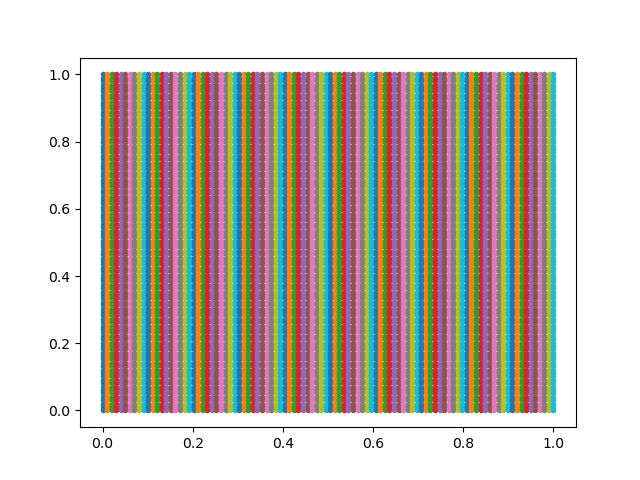

In [3]:
#create mesh grid
x = np.linspace(0,1,N)
y = np.linspace(0,1,N)
X, Y = np.meshgrid(x,y)
plt.plot(X, Y, ls='None', marker='.')

In [4]:
#now define our boundary conditions
def define_boundary(N,x):
    phi = np.zeros(shape=[N,N])
    for i in range(0,N):
        for j in range(0,N):
            if i==0: phi[i][j]=324*(x[j])*(x[j])*(1-x[j]) #where x_j = j*h
            elif i==N-1: phi[i][j]=-324*(x[j])*(x[j])*(1-x[j]) #where x_j = j*h
            else:
                 next 
    return(phi)
        
ph = define_boundary(N,x)
ph

array([[ 0.        ,  0.03272393,  0.12956006, ...,  6.28366308,
         3.20694549,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.        , -0.03272393, -0.12956006, ..., -6.28366308,
        -3.20694549, -0.        ]])

Dirichlet boundary gets us the u at boundaries, so in order to assemble the matrix sistem, we throw the boundaries values to the right hand side of the equation written above. So we get $\tilde{f}$ while putting the values in the same column

In [5]:
def assembly_rhs(f, phi):
    ft = f
    ft[1,:] = ft[1,:] - phi[0,:]/(h**2)     #down points next to boundary
    ft[-2,:] = ft[-2,:] - phi[-1,:]/(h**2)  #top points next to boundary
    ft[:,-2] = ft[:,-2] - phi[:,-1]/(h**2)  #right points next to boundary
    ft[:,1] = ft[:,1] - phi[:,0]/(h**2)     #left points next to boundary
    ft = ft[1:-1, 1:-1]                     #exclude boundaries
    ft = ft.transpose()
    ft = ft.flatten('F') #transpose is for right order, flatten for 2d matrix -> 1d vector by stacking columns F-Fortran
    return(ft)

ft = assembly_rhs(f, ph)
#ft

Lets now assemble the matrix A:

$
\begin{bmatrix} 
    T & I & \dots \\
    I & T & \\
    \vdots &  &\ddots       
\end{bmatrix}
$

with T being:

$
\begin{bmatrix}
-4 & 1 & 0 & \dots \\
1 & -4 & \ddots & \dots \\
0 & \ddots &\ddots  &1 \\
 \vdots& \vdots& 1 & -4
\end{bmatrix}
$

In [6]:
I = np.eye(M) # I matrix
#print(I)

In [7]:
T = spdiags([np.ones(M), -4*np.ones(M), np.ones(M)], [-1, 0, 1], M, M) #T matrix
#print(T.toarray())

In [8]:
S = spdiags([np.ones(M), np.ones(M)], [-1, 1], M, M) #S matrix
#print(S.toarray())

In [9]:
A = (kron(I,T) + kron(S,I))/(h**2) #assemble A matrix by kroniker multiplication
#print(A.toarray())

Now let's solve the sistem $A*u=\tilde{f}$

In [10]:
u = np.linalg.solve(A.toarray(), ft)
#u

In [11]:
u = np.reshape(u, (M,M))
#u

In [12]:
ph[1:-1,1:-1] = ph[1:-1,1:-1] + u
#ph

In [13]:
#plt.imshow(ph)

C:\Users\krili\AppData\Local\Temp/ipykernel_12924/1716023805.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


AttributeError: 'Axes3DSubplot' object has no attribute 'get_array'

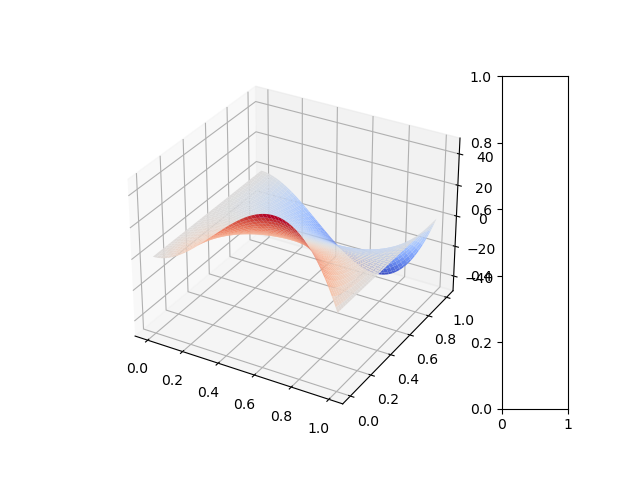

In [18]:

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X,Y,ph, cmap="coolwarm")
plt.show()